# Predicting the customers future purchase

**Goal: Use the historical customer transaction data to predict the customers' future widgets purchase**


## Steps:
1. Data Exploration and Preprocessing:
    - Understand Data
    - Data Cleaning: missing values, duplicates, outliers, etc.
    - Feature Engineer: if there is any feature needed to be convert to the right data type
    - Split data: Calibration and holdout data set
    - Analyze and visualize: the prepared data before fit the models
    
2. Model Implementation:
    - ModifiedBetaGeoFitter:
        - Analysis model performance
        - Generate predictions
    - GammaGammaFitter
        - Analysis model performance
        - Generate predictions
        
    - Combine a CLV
        
3. Predicting Future Customer Behavior:
    - Simulation
    - Segmentation
    - Performance Evaluation
    
4. Summary

In [1]:
import pandas as pd
import numpy as np
import os
import datetime as dt
import pickle

from typing import Dict, Tuple, List
import logging

from lifetimes import ModifiedBetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions

import matplotlib.pyplot as plt
import seaborn as sns


from helper_function import *
import warnings
warnings.filterwarnings('ignore')

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger()

# 1. Data Exploration and Preprocessing:
- Load the dataset from the provided CSV file.
- Ensure the data is in the correct format for analysis:
    -     Check if it is the right format, otherwise, converting it into a suitable format.
- Dataset detail:
    - `CustomerID`: it's possible to have multiple rows with the same CustomerID
    - `Timestamp`: a UTC timestamp of the transaction 
    - `PurchaseValue`: the monetary value of the transaction
    
- Prepare the data for the lifetimes models, get Recency, Frequency, Monetary

In [2]:
def explore_data(data: pd.DataFrame):
    """
    Check the data.
    """
    print("############### Shape ###############")
    print(data.shape)
    print("############### Types ###############")
    print(data.dtypes)
    print("################################# Head #################################")
    print(data.head())
    print("############### Nulls ###############")
    print(data.isnull().sum())
    print("################################# Describe #################################")
    print(data.describe().T)
    print("################################# Timestamp Info #################################")
    print(data.Timestamp.min(), data.Timestamp.max())
    print("\nUnique Values Count in Each Column:")
    for column in data.columns:
        print(f"{column}: {data[column].nunique()}")

In [3]:
file_path = os.path.join(os.getcwd(), "data.csv")
data = read_data(file_path)
explore_data(data)

############### Shape ###############
(49945, 3)
############### Types ###############
CustomerID        object
Timestamp         object
PurchaseValue    float64
dtype: object
################################# Head #################################
                         CustomerID             Timestamp  PurchaseValue
0  5611860a94204a4078659f1667372cc4  2017-02-09T18:31:00Z           4.72
1  07b260307114f9cffc5601eb7ad4b565  2017-06-28T19:26:00Z           5.33
2  1ede55062d0d68c70fc4d355a5328d11  2017-07-28T17:47:00Z           5.35
3  42b8e86e8da5e35628bcdc146c358665  2016-12-17T22:59:00Z           6.00
4  1047f2787b7efc759d7ffcbc40ef7e19  2016-12-05T17:23:00Z           6.28
############### Nulls ###############
CustomerID       0
Timestamp        0
PurchaseValue    0
dtype: int64
################################# Describe #################################
                 count        mean         std   min   25%     50%     75%  \
PurchaseValue  49945.0  236.888196  245.760987  4.

**No missing values, but feature Timestamp needs to be converted to the right datatype, and we have some outliers need to check**

In [4]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [5]:
data.CustomerID.value_counts().describe()

count    23708.000000
mean         2.106673
std          2.330419
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        135.000000
Name: count, dtype: float64

In [6]:
data["Timestamp"].max() - data["Timestamp"].min()

Timedelta('371 days 13:06:00')

We have 23,708 unique customers, and 50% of the customers have only 1 purchase. We want to know who of these customers is likely to continue buying the product. 

**Also, from the basic stats, we can see the PurchaseValue have some outliers, let's visualize and run an outliers detection.**

In [7]:
def outlier_analysis(df: pd.DataFrame, column: str) -> None:
    """Outlier stats analysis using 3 stdev"""
    mean = df[column].mean()
    std = df[column].std()
    
    outliers = df[(df[column] > mean + 3 * std) | (df[column] < mean - 3 * std)]
    data_cleaned = df[(df[column] >= mean - 3 * std) & (df[column] <= mean + 3 * std)]
    data_cleaned = data_cleaned.reset_index(drop=True)

    # Visualize feature's outliers
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    # Boxplot
    sns.boxplot(x=df[column], ax=axs[0])
    axs[0].set_title(f"Box Plot of {column}")

    # Histogram
    sns.histplot(df[column], kde=True, ax=axs[1])
    axs[1].set_title(f"Histogram of {column}")
    plt.show()
    
    return outliers, data_cleaned

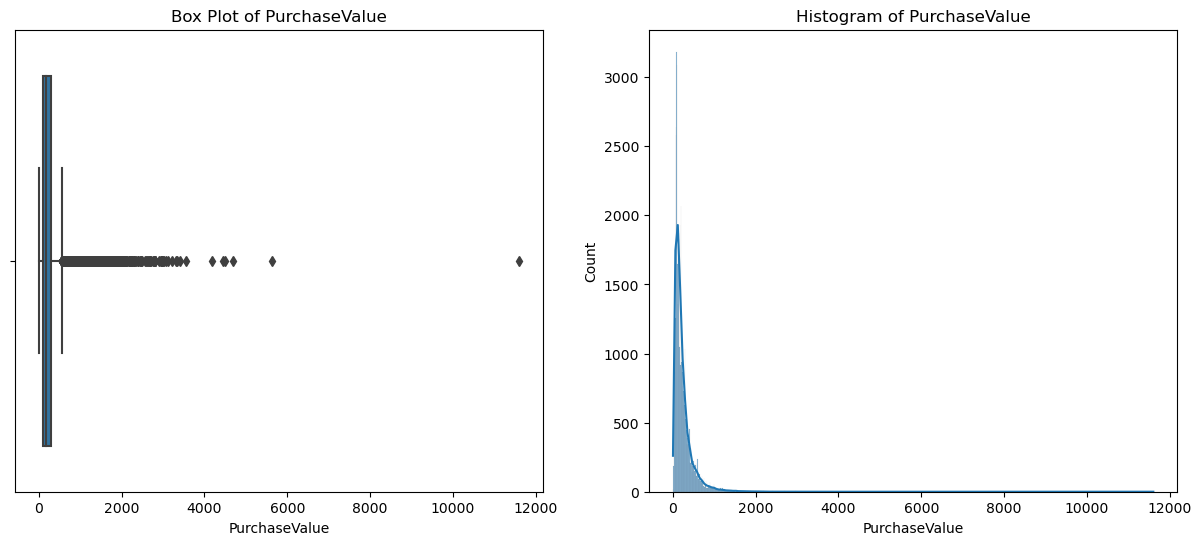

In [8]:
outliers, data_cleaned = outlier_analysis(data, column="PurchaseValue")

In [9]:
data_cleaned.describe()

,PurchaseValue
count,49003.000000
mean,214.656849
std,169.074160
min,4.720000
25%,96.870000
50%,163.000000
75%,275.390000
max,973.800000


**In some cases, high-value transactions might be normal and should not be considered as outliers, however, we don't have enough information of this dataset, for example, what is this ecommerce store? what are the product/service types of this ecommerce sell? what are these high-value transacations' product type (i.e. computer, jewelry, etc)? what is the basic price rate for each of the product/service type?If I have more information, it would be easier to trime the outliers.**

Let's take a look at the maximum purchase value's info

In [10]:
data[data['PurchaseValue']==11599.68]

,CustomerID,Timestamp,PurchaseValue
49944,dca76db00cc59dfbcdcc97c8bbc7f9f1,2016-12-21 19:27:00+00:00,11599.68


In [11]:
data[data['CustomerID']=='dca76db00cc59dfbcdcc97c8bbc7f9f1'].shape

(24, 3)

In [12]:
data[data['CustomerID']=='dca76db00cc59dfbcdcc97c8bbc7f9f1'].describe()

,PurchaseValue
count,24.000000
mean,797.443333
std,2311.086000
min,64.870000
25%,109.365000
50%,299.285000
75%,499.380000
max,11599.680000


In [13]:
# let's drop the row with the extreme outlier 
data = data[data['PurchaseValue']!=11599.68]
data.describe()

,PurchaseValue
count,49944.000000
mean,236.660685
std,240.446278
min,4.720000
25%,97.097500
50%,166.660000
75%,286.775000
max,5626.450000


In [14]:
data[data['PurchaseValue']>=1000].shape

(851, 3)

## 1.1 Prepare the data for the lifetimes models:

### 1.1.1 Get RFM for each customer:
- `R`: Recency, the duration between a customer's first purchase and their latest purchase. 
- `F`: Frequency, the number of a customer repeat purchases. 
- `M`: Monetary Value, the average PurchaseValue of a customer, excluding the first purchase

Since we have ~ 50k rows and the data spans over a year, we have a substantial amount of data, which allow me to create both a calibration set for training and a holdout set for validation

In [15]:
# total number of days are 371, lets use 270 to split the data into calibration and holdout
def prepare_model_data(data: pd.DataFrame, file_path: str, cali_period_days: int = 270) -> None:
    """
    Prepare calibration-holdout data for the models.
    data: transaction data.
    cali_period_days: Number of days for the calibration period.
    file_path: The path to save the prepared data.
    """
    try:
        diff_time = data["Timestamp"].max() - data["Timestamp"].min()
        print(diff_time)
        cali_date = data["Timestamp"].min() + dt.timedelta(days=cali_period_days)
        obs_date = cali_date + (diff_time - dt.timedelta(days=cali_period_days))
        print(cali_date, obs_date)

        # daily holdout data
        daily_holdout = calibration_and_holdout_data(
            transactions=data, 
            customer_id_col="CustomerID",
            datetime_col="Timestamp", 
            monetary_value_col="PurchaseValue",
            calibration_period_end=cali_date,
            observation_period_end=obs_date,
            freq="D"
        )
        
        # daily summary data
        daily_summary = summary_data_from_transaction_data(
            transactions=data, 
            customer_id_col="CustomerID", 
            datetime_col="Timestamp", 
            monetary_value_col="PurchaseValue",
            freq = "D"
        )
        
        daily_holdout.to_pickle(f"{file_path}\\model_data\\daily_holdout.pkl")
        daily_summary.to_pickle(f"{file_path}\\model_data\\daily_summary.pkl")
        
        return daily_holdout, daily_summary
    
        logger.info("Data preparation and saving completed successfully.")
    except Exception as e:
        logger.error(f"Error in preparing model data: {e}")
        raise
        
daily_holdout,daily_summary = prepare_model_data(data, file_path=os.path.join(os.getcwd())) 

371 days 13:06:00
2017-08-27 04:47:00+00:00 2017-12-06 17:53:00+00:00


In [16]:
# training frequency
pd.options.display.float_format = '{:,.3f}'.format
x = daily_holdout["frequency_cal"].value_counts()
x = x.nlargest(15)
print("Num of repeat purchase:")
x.sort_index(ascending=True)

Num of repeat purchase:


frequency_cal
0.000     11645
1.000      3484
2.000      1587
3.000       746
4.000       427
5.000       240
6.000       131
7.000        84
8.000        46
9.000        37
10.000       18
11.000       16
12.000       14
13.000       13
15.000        8
Name: count, dtype: int64

### 1.1.2 Preparing data to fit Gamma-Gamma Model:
- Filter out customers who have made 0 repeat purchase as the Gamma-Gamma model only applies to repeat customers.

In [17]:
ggf_holdout = daily_holdout.copy()
ggf_holdout.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
CustomerID,,,,,,,
0001117ff1305c1fe840697166e61564,1.000,11.000,243.000,87.280,0.000,0.000,101.000
00028502859fd7e111d88c20456b59d5,0.000,0.000,241.000,0.000,0.000,0.000,101.000
0003f3458a6e7b495a975c2d9ddda559,1.000,2.000,242.000,76.630,1.000,99.500,101.000
000784b838b807ad589d4bc69c0c562f,0.000,0.000,109.000,0.000,0.000,0.000,101.000
000ad0f90e9fcb6ff5a0bc480cccbdb3,5.000,68.000,99.000,229.782,0.000,0.000,101.000


## 1.2 Plot the distribution plot to check the frequency and monetary value before filter out non-repeat customers

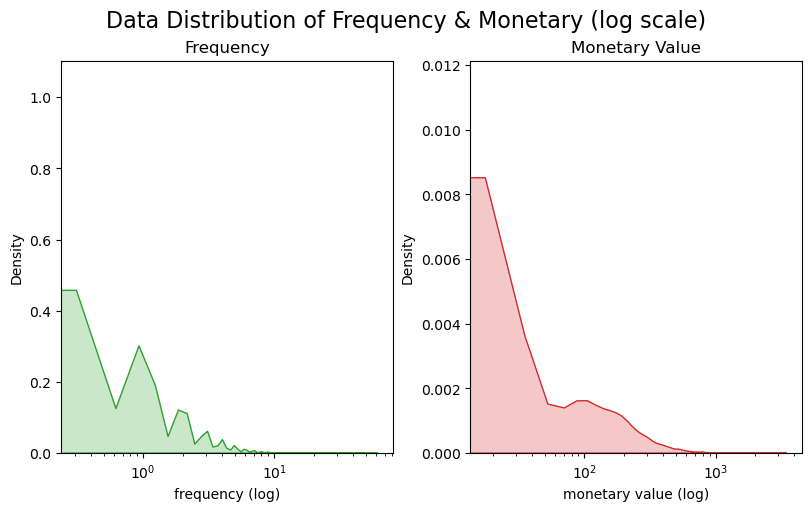

In [18]:
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(8, 5),
    sharex=False,
    sharey=False,
    layout="constrained"
)
sns.kdeplot(x="frequency_cal", data=ggf_holdout, color="C2", clip=(0.0, None), fill=True, ax=ax[0])
ax[0].set(title="Frequency",xlabel="frequency (log)",xscale="log")

sns.kdeplot(x="monetary_value_cal", data=ggf_holdout, color="C3", clip=(0.0, None), fill=True, ax=ax[1])
ax[1].set(title="Monetary Value",xlabel="monetary value (log)",xscale="log")

fig.suptitle("Data Distribution of Frequency & Monetary (log scale)", fontsize=16);

## 1.3 Remove the non-repeat customers and check the correlation between frequency and monetary_value
- To ensure that we can use Gamma Gamma, we need to check if frequency and monetary values are not correlated.

                    frequency_cal  monetary_value_cal
frequency_cal               1.000               0.033
monetary_value_cal          0.033               1.000


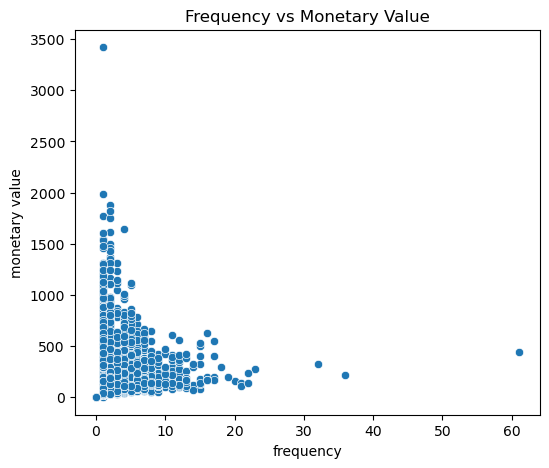

In [19]:
# Getting rid of non repeat customers
returning_customers_summary = ggf_holdout[ggf_holdout['frequency_cal']>0]

#Check the correlation 
print(returning_customers_summary[["frequency_cal", "monetary_value_cal"]].corr())

fig, ax = plt.subplots(figsize = (6,5))
sns.scatterplot(x="frequency_cal", y="monetary_value_cal", data=ggf_holdout, ax=ax)
ax.set(title="Frequency vs Monetary Value",xlabel="frequency",ylabel="monetary value");

**The two arrays are very weakly correlated with correlation coefficient of only 0.033. Thus, we can fit and evaluate the Gamma-Gamma model**

# 2. Model Implementation using Lifetimes
- Implementing the Modified Beta Geometric
- Implementing the Gamma-Gamma Model

In [20]:
def fit_models(hold_out_data: pd.DataFrame) -> Tuple[ModifiedBetaGeoFitter, GammaGammaFitter]:
    """
    Fit both Modified Beta Geometric and Gamma Gamma models on the calibration and holdout data.
    hold_out_data: The calibration and holdout df.
    Returns: Fitted MBG and Gamma Gamma models.
    """
    mbg_model = ModifiedBetaGeoFitter()
    mbg_model.fit(hold_out_data['frequency_cal'], 
                  hold_out_data['recency_cal'], 
                  hold_out_data['T_cal'])
    
    gamma_gamma_model = GammaGammaFitter()
    # remove non repeat customers.
    repeat_customers = hold_out_data[hold_out_data['frequency_cal'] > 0]
    gamma_gamma_model.fit(repeat_customers['frequency_cal'], 
                          repeat_customers['monetary_value_cal'])                
    return mbg_model, gamma_gamma_model

In [21]:
mbgf, ggf = fit_models(hold_out_data = daily_holdout)

## 2.1 Modified Beta Geometric model:
### 2.1.1 Check the model performance

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

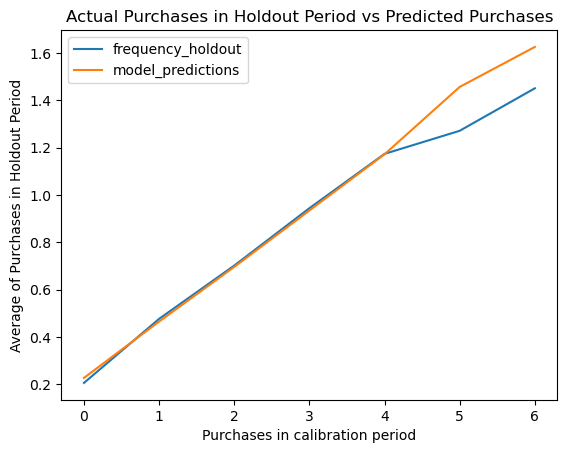

In [22]:
# Evaluating the performance of the model pred vs actual
plot_calibration_purchases_vs_holdout_purchases(mbgf, daily_holdout)

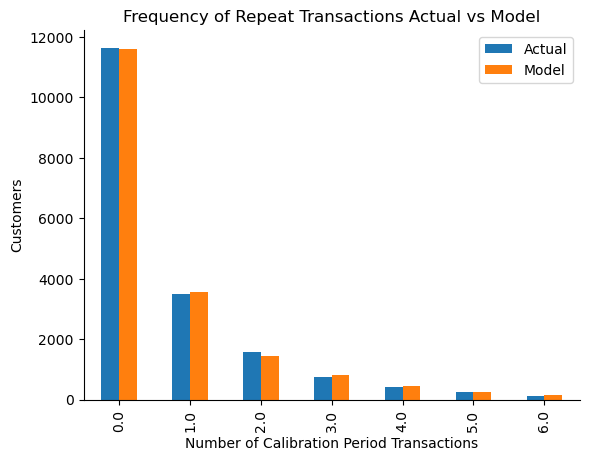

In [23]:
# Plot a figure with period actual and predicted transactions.
ax = plot_period_transactions(mbgf, title='Frequency of Repeat Transactions Actual vs Model')
sns.despine();

- Above plot compares the frequencies between our actual data and predict data from the distributions generated by the ModifiedBetaGeo model.
- The plot indicates our model effectively captures the underlying process.

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

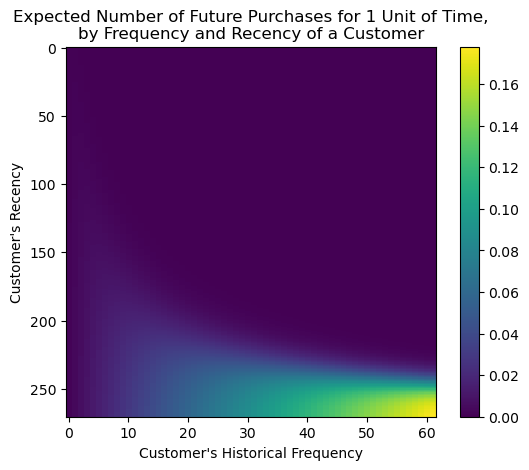

In [24]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(mbgf)

From the Frequency/Recency/Future Purchases Matrix plot, we can see:
- The best customers are in the bottom right corner — these customers made frequent purchases quite recently, so we have a high expectation they’ll come back.
- While, in the top right corner, these customers made frequent purchases and then stopped coming back. It is likely they’ve deactivated

### 2.1.2 Generate future customer purchase prediction
 - Write a function to generate predictions based on given time frame
 - Generate the future purchase predictions 

In [25]:
def predict_future_purchases(data: pd.DataFrame, mbg_model, prediction_name: str, time_frame_days: int) -> pd.DataFrame:
    """
    Predict the number of future purchases within the given time frame for each customer.
    
    data: The df containing customer data with columns 'frequency_cal', 'recency_cal', and 'T_cal'.
    mbg_model: The fitted Modified BG model.
    prediction_name: The name of the column to store the predictions.
    time_frame_days: The time frame in days for which to predict future purchases.
    
    Returns: The df with predicted number of purchases for each customer.
    """
    required_columns = {'frequency_cal', 'recency_cal', 'T_cal'}
    if not required_columns.issubset(data.columns):
        raise ValueError(f"Data is missing one of the required columns: {required_columns}")

    future_purchases = data.copy()
    future_purchases[prediction_name] = mbg_model.conditional_expected_number_of_purchases_up_to_time(
        t=time_frame_days,
        frequency=future_purchases['frequency_cal'],
        recency=future_purchases['recency_cal'],
        T=future_purchases['T_cal']
    )
    future_purchases = future_purchases.sort_values(by=prediction_name, ascending=False)

    return future_purchases

In [26]:
#  Get customers predicted to make the most purchases over the next 12 months use mbgf model
future_purchase_12m = predict_future_purchases(data=daily_holdout, 
                                               mbg_model = mbgf, 
                                               prediction_name="predicted_purchases_12m", 
                                               time_frame_days=365)
future_purchase_12m

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases_12m
CustomerID,,,,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,61.000,269.000,270.000,439.110,34.000,262.559,101.000,48.068
48a503edbaded96a3be27deee11967a1,36.000,262.000,270.000,219.839,10.000,185.645,101.000,27.791
5f01420f0edda6555df5ce1cc62b986c,32.000,269.000,269.000,324.531,7.000,182.973,101.000,25.496
6d61ac78f193cf9237f3ebfeede61704,18.000,168.000,171.000,298.677,4.000,289.466,101.000,18.527
d6415e9e368a32ba39f756716c94e754,22.000,242.000,247.000,239.419,1.000,210.330,101.000,18.313
...,...,...,...,...,...,...,...,...
5fe830ff7ba5062b21d7c764c89a81e9,4.000,9.000,232.000,161.395,0.000,0.000,101.000,0.056
fcab6b1b4370519b099f59dc436fa2cb,5.000,24.000,253.000,"1,117.436",0.000,0.000,101.000,0.036
64a0747c72dba75d4318ec5009d7d2c6,5.000,22.000,257.000,111.720,0.000,0.000,101.000,0.030


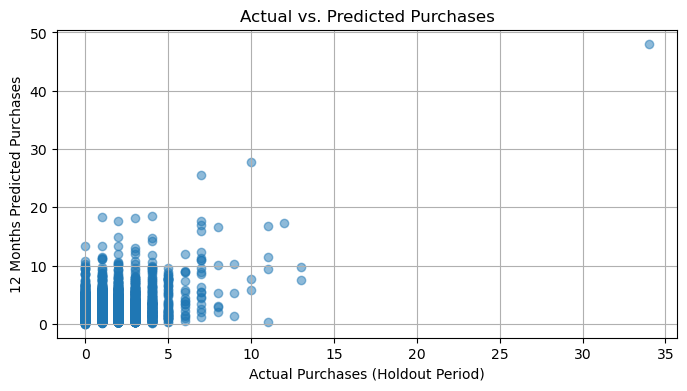

In [27]:
plt.figure(figsize=(8, 4))
plt.scatter(future_purchase_12m['frequency_holdout'], future_purchase_12m['predicted_purchases_12m'], alpha=0.5)
plt.title('Actual vs. Predicted Purchases')
plt.xlabel('Actual Purchases (Holdout Period)')
plt.ylabel('12 Months Predicted Purchases')
plt.grid(True)
plt.show()

**The scatter plot for the MBG model shows a clustering of points along the bottom of the chart, indicating that many actual purchases during the holdout period were 0, which the model predicted showes that it would be higher. Additionally, there seems to be a positive relationship for some customers, but with a large variance.**

In [28]:
future_purchase_12m[['frequency_holdout','predicted_purchases_12m']].describe()

,frequency_holdout,predicted_purchases_12m
count,"18,519.000","18,519.000"
mean,0.412,1.233
std,0.940,1.388
min,0.000,0.015
25%,0.000,0.453
50%,0.000,0.812
75%,1.000,1.443
max,34.000,48.068


The above descriptive statistics shows a wide range of actual values for frequency, with a significant number of customers making no repeat purchases during the holdout period. This long-tail distribution is common in customer purchase data and can be challenging for models to predict accurately, especially at the individual customer level.

- The actual data has a low mean (0.412) with a standard deviation (0.940) that suggests wide variability in customer purchase frequency.

- The model predicts a higher mean number of purchases (1.233) over the next 12 months than what was observed in the holdout data, showing an optimistic forecast of customer purchasing behavior.

- The standard deviation of the predicted purchases (1.388) is also higher than the actual holdout data, which could imply that the model is overestimating the variation in purchasing behavior among customers.

- The median of actual purchases is 0, meaning that more than half of the customers did not make any repeat purchases during the holdout period. While, the model predict a median of 0.812, suggesting that it expects most customers to make at least one repeat purchase in the next 12 months.

In [29]:
from sklearn.metrics import mean_absolute_error

purchase_mae_holdout = mean_absolute_error(y_true = future_purchase_12m["frequency_holdout"],
                          y_pred = future_purchase_12m["predicted_purchases_12m"])

purchase_mae_holdout

1.0394860600555322

Mean absolute error is ~1.04, which is quite good for this untuned model. This value indicates that on average, the MBG model's predictions are about 1.04 purchases away from the actual number of repeat purchases made by customers during the holdout period.

### 2.1.3 List top customers predicted make the most purchase over the next 12 months

In [30]:
top_100_customers_purchase_num_prediction = future_purchase_12m[:100]['predicted_purchases_12m'].to_frame()
# store top 100 customers predicted make the most purchase over the next 12 months in a list
top100_customers_purchase_list = top_100_customers_purchase_num_prediction.index.tolist()
# top_100_customers_purchase_num_prediction.to_csv(r"model_data/top100_customer_purchases.csv")
top_100_customers_purchase_num_prediction.head()

,predicted_purchases_12m
CustomerID,
a5fadc51b1ae844ad9a70ad3cfa46a64,48.068
48a503edbaded96a3be27deee11967a1,27.791
5f01420f0edda6555df5ce1cc62b986c,25.496
6d61ac78f193cf9237f3ebfeede61704,18.527
d6415e9e368a32ba39f756716c94e754,18.313


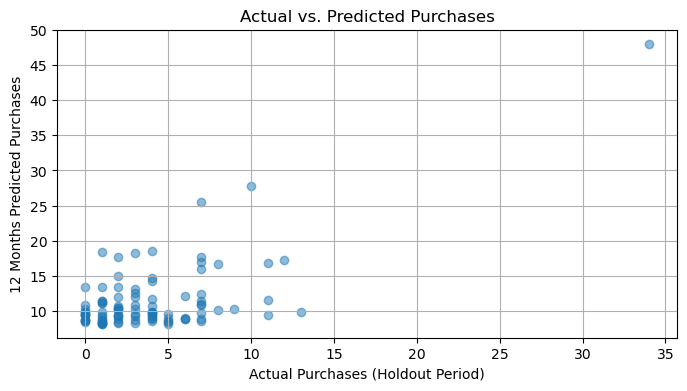

In [31]:
top_100_ = future_purchase_12m[:100][["frequency_holdout", "predicted_purchases_12m"]]

plt.figure(figsize=(8, 4))
plt.scatter(top_100_['frequency_holdout'], top_100_['predicted_purchases_12m'], alpha=0.5)
plt.title('Actual vs. Predicted Purchases')
plt.xlabel('Actual Purchases (Holdout Period)')
plt.ylabel('12 Months Predicted Purchases')
plt.grid(True)
plt.show()

For the selected top 100 customers:
- the customers with 0 actual repeat purchases during the holdout period were predicted to make repeat purchases in the next 12 months (an optimistic forecast by our model)
- the customers with actual repeat purchases, the model predicts a higher number of purchases in many data points 

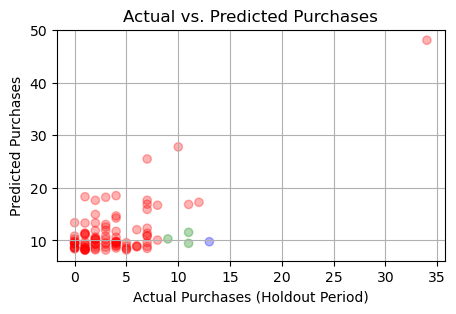

In [32]:
#threshold for accuracy (e.g., 20%)
threshold = 0.20 

# Difference between actual and predicted purchases
diff = top_100_['predicted_purchases_12m'] - top_100_['frequency_holdout']
percent_diff = diff / top_100_['frequency_holdout']

# prediction is within the threshold are colored green (accurate).
# prediction is higher than the actual value by more than the threshold are colored red (overestimation).
# prediction is lower than the actual value by more than the threshold are colored blue (underestimation).
# assign colors based on the difference
colors = ['green' if -threshold <= p <= threshold else 'red' if p > 0 else 'blue' for p in percent_diff]

plt.figure(figsize=(5, 3))
plt.scatter(top_100_['frequency_holdout'], top_100_['predicted_purchases_12m'], alpha=0.3, c=colors)
plt.title('Actual vs. Predicted Purchases')
plt.xlabel('Actual Purchases (Holdout Period)')
plt.ylabel('Predicted Purchases')
plt.grid(True)
plt.show()

- Since we choose 20% as our threshold for accuracy (selected top 100 predicted purchases customers),the above plot shows that most of the model predicted repeat purchases are generally overestimate, especially as the number of actual purchases increases. 
- Overestimation could lead to inflated expectations for future revenue and could potentially result in overstocking or misallocation of marketing resources. 
- While, underestimation could lead to missed opportunities for engaging with potentially loyal customers.

## 2.2 Modeling with Gamma-Gamma Model
### 2.2.1 Generate predictions and Check the model performance

In [33]:
# future_value = returning_customers_summary.copy()
returning_customers_summary['monetary_pred'] = ggf.conditional_expected_average_profit(returning_customers_summary['frequency_holdout'],
                                                                                       returning_customers_summary['monetary_value_holdout'])

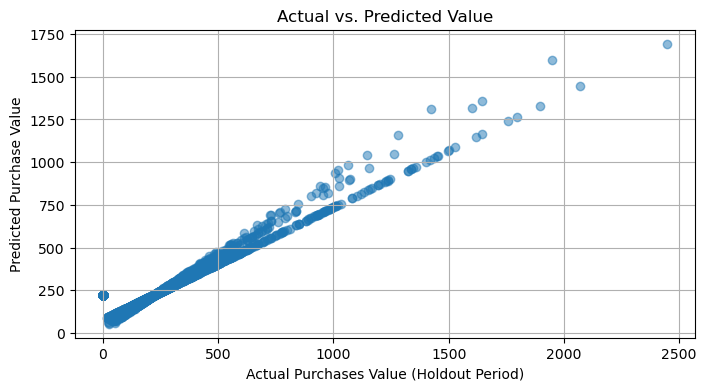

In [34]:
plt.figure(figsize=(8, 4))
plt.scatter(returning_customers_summary['monetary_value_holdout'], returning_customers_summary['monetary_pred'], alpha=0.5)
plt.title('Actual vs. Predicted Value')
plt.xlabel('Actual Purchases Value (Holdout Period)')
plt.ylabel('Predicted Purchase Value')
plt.grid(True)
plt.show()

- The above scatter plot shows that the model's predictions are correlated with actual customer spending. This is a positive indication that the model is capturing the underlying spending patterns to some extent.
- Most of points along the line where the predicted value equals the actual value, which indicates accurate predictions for most of the customers. while, there are also points that deviate from this line, indicating areas where the model's predictions were less accurate.
- The model assumes that spending patterns are similar over time. so if there are customers with changing spending behavior, the model may not capture this well, leading to inaccuracies for those individuals.

In [35]:
ggf_mae_holdout = mean_absolute_error(y_true = returning_customers_summary["monetary_value_holdout"],
                                      y_pred = returning_customers_summary['monetary_pred'])

ggf_mae_holdout 

144.77596779094588

The Gamma-Gamma model shows the MAE for the monetary predictions is ~145, so model's on average, the predictions are 145 away from the actual spending amount per customer during the holdout period, compared to the mean actual purchase value of approximately $109.Since this exercise only have a year's transactions data, and our time is limited, but if we have more years of transactoins data, and can spend more time on model tunning, we could improve the gamma-gamma model performance.

In [36]:
returning_customers_summary[['monetary_value_holdout','monetary_pred']].describe()

,monetary_value_holdout,monetary_pred
count,"6,874.000","6,874.000"
mean,109.055,233.323
std,196.886,108.558
min,0.000,53.748
25%,0.000,222.648
50%,0.000,222.648
75%,163.194,222.648
max,"2,445.270","1,693.596"


Above stats shows, the mean predicted value is more than twice the mean actual value, which means that the model tends to overestimate customer spend. The standard deviation of the predicted monetary value is lower than the actual value shows the model may not capture the full variablitiy in customer spending.

## 2.3 Combined CLV Model
- Customer Lifetime Value (CLV) is a metric that estimates the total revenue a business can reasonably expect from a single customer account throughout the business relationship. It combines the frequency of purchases, the average monetary value of these purchases, and the length of the customer-business relationship.

- The "customers predicted to spend the most" are essentially those with the highest CLV

In [37]:
# This method computes the average lifetime value for a group of one or more customers.
clv = ggf.customer_lifetime_value(
    mbgf, # model to use to predict the number of future transactions
    returning_customers_summary['frequency_cal'],
    returning_customers_summary['recency_cal'],
    returning_customers_summary['T_cal'],
    returning_customers_summary['monetary_value_cal'],
    time=12, # months
    discount_rate=0.01 # monthly adjusted discount rate
)

returning_customers_summary['clv_12mth'] = clv
returning_customers_summary = returning_customers_summary.sort_values(by = ['clv_12mth','monetary_pred'], ascending=False)
returning_customers_summary.head()

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,monetary_pred,clv_12mth
CustomerID,,,,,,,,,
a5fadc51b1ae844ad9a70ad3cfa46a64,61.000,269.000,270.000,439.110,34.000,262.559,101.000,261.968,"19,612.561"
42059a7ede026d409ff0f255635d7a08,16.000,222.000,225.000,630.774,4.000,565.376,101.000,526.551,"8,227.258"
5f01420f0edda6555df5ce1cc62b986c,32.000,269.000,269.000,324.531,7.000,182.973,101.000,185.672,"7,681.155"
742d5a52d4df7cb14246d7f390de5d8a,15.000,242.000,255.000,531.223,6.000,441.583,101.000,424.400,"5,859.329"
48a503edbaded96a3be27deee11967a1,36.000,262.000,270.000,219.839,10.000,185.645,101.000,187.444,"5,700.709"


In [38]:
returning_customers_summary[[ 'clv_12mth']].describe()

,clv_12mth
count,"6,874.000"
mean,455.058
std,557.086
min,3.389
25%,179.826
50%,299.192
75%,532.586
max,"19,612.561"


The above stats shows that total 6,874 customers' Customer Lifetime Vlue has been calculated and the average predicted CLV for the next 12 months across all these customers is ~$455, which means the average amount each customer is expected to contribute to the profit. The standard deviation is ~557 shows that the customers' values are spread out over a wide range, and some of the customers predicted to be more valueable than others. The min predicted clv is ~3 means the least valueable customer is still expected to bring some revenue over the next 12 months, while he highest predicted CLV is ~19k, which shows the model predicts one/some customers to be extremely valuable to the ecommerce store.

## 2.4 Summary based on the models and overall analysis

**Do you think those assumptions are valid for a model of a customer buying widgets from an ecommerce store?**

- Both models helped us understanding customer behaviors, theses assumptions may need re-evaluation to better accurately reflect the customers' purchasing patterns of buying widgets from an e-commerce store. Model retuning, and add additional data could improve the accuracy of these predictions.
    - Both of the modified BG model and Gamma-Gamma model showed us they are over-estimated the customers' purchases and spend value. 
    - For the Modified BG model, we could make some adjustments for the model or use some alternative approaches to account for the high incidence of less repeat customers
    - For the gamma-gamma model, the overestimation of spend and assumption of spending behavior may not be fully approriate for e-commerce, where customers spending can be impacted by promotions, seasonality, or personal preferences, etc.
    - So further model tuning may be necessary, especially if more data become available


# 3. Predicting Future Customer Behavior:

- Simulation
- Segmentation

In [42]:
# use the previous fitted models and customized mbg pred functions
# randomly select 100 sample customers
# how many customers are alive after 10 days, 1 year, 10 years and 100 years 
# how many purchases they have made in that time using the modified BG model. 
def simulate_customer_behavior(data: pd.DataFrame, mbg_model, time_frames: List[int]) -> pd.DataFrame:
    """
    Simulate customer behavior over diff time frames.
    time_frames: List of time frames (in days) to simulate (e.g., [10, 365, 3650, 36500] for 10 days, 1 year, 10 years, 100 years).
    Returns: The df with number of purchases and alive status of customers at each time frame.
    """
    df = data.copy()
    # a random sample of 100 customers
    sampled_customers = df.sample(100, random_state=np.random.randint(10000))
    simulation_results = pd.DataFrame(index=sampled_customers.index)

    for days in time_frames:
        # Predict custommers purchanses on diff time frames
        simulation_results[f'purchases_{days}_days'] = mbg_model.conditional_expected_number_of_purchases_up_to_time(
            t=days,
            frequency=sampled_customers['frequency_cal'],
            recency=sampled_customers['recency_cal'],
            T=sampled_customers['T_cal']
        )

        # Compute the probability of being alive on diff timefraems
        simulation_results[f'prob_alive_{days}_days'] = mbg_model.conditional_probability_alive(
            frequency=sampled_customers['frequency_cal'],
            recency=sampled_customers['recency_cal'],
            T=sampled_customers['T_cal']
        )  
        
        # Count how many purchases the cusotmers have made in diff time frames
        total_purchases = simulation_results[f'purchases_{days}_days'].sum().round()
        # Count how many cusotmers are alive in diff time frames by setting up the threshold at 0.5
        total_alive = (simulation_results[f'prob_alive_{days}_days']>0.5).sum().round()
        print(f"Total purchases in {days} days: {total_purchases}. Total customers are alive after {days} days: {total_alive}\n")
        
    return simulation_results

In [43]:
# 10 days, 1 year, 10 years, 100 years
time_frames = [10, 365, 3650, 36500]  # 10 days, 1 year, 10 years, 100 years
# the alive threshold is setted as 0.5
simulation_results = simulate_customer_behavior(data=daily_holdout, mbg_model=mbgf, time_frames=time_frames)
simulation_results

Total purchases in 10 days: 5.0. Total customers are alive after 10 days: 59

Total purchases in 365 days: 132.0. Total customers are alive after 365 days: 59

Total purchases in 3650 days: 560.0. Total customers are alive after 3650 days: 59

Total purchases in 36500 days: 1450.0. Total customers are alive after 36500 days: 59



,purchases_10_days,prob_alive_10_days,purchases_365_days,prob_alive_365_days,purchases_3650_days,prob_alive_3650_days,purchases_36500_days,prob_alive_36500_days
CustomerID,,,,,,,,
69a78dd6eab193bf9420e17bb1dff949,0.057,0.693,1.672,0.693,7.814,0.693,21.014,0.693
5cd2f869d81417f4b77ecd14b9718aa3,0.033,0.562,0.859,0.562,3.588,0.562,9.363,0.562
2ccadeb8c45642fe914020a9f630076d,0.017,0.466,0.492,0.466,2.329,0.466,6.544,0.466
23f8c41c6b94bd01a67c145f00358631,0.025,0.519,0.671,0.519,2.968,0.519,8.001,0.519
c0f60031347662c7af75c5c3b4a75650,0.113,0.775,3.205,0.775,14.202,0.775,36.882,0.775
...,...,...,...,...,...,...,...,...
37a717c3297bd6efb940bc03c3fe8e80,0.047,0.730,1.369,0.730,6.312,0.730,16.982,0.730
026a27bbbf324d9959ee0efc7705b126,0.030,0.548,0.793,0.548,3.377,0.548,8.904,0.548
2a922e210458deb87a2144133266a34f,0.080,0.666,2.174,0.666,9.104,0.666,23.058,0.666


For very long time frames, i.e. 10 years or 100 years, the MBG model might not accurately reflect the decay in customer activitities, because such periods are beyond the typical scope of customer lifetime value models. The model is usually calibrated on shorter-term timeframe data and may not extrapolate well over many decades. Since in our simulation, we use a random sample of 100 customers, the sampled 100 customers may have a lower churn rate. But different samples could yield different results, especially given that we're looking at only one simulation run.

## 4. Analysis of results 
- based on model result
- simulation result


**1. What the model works well:**

- For shorter timeframes, the MBG model is effective/accurately in predicting purchase frequency
- The Gamma-Gamma model accurately segments customers based on their spending patterns, which is useful for targeted marketing strategies.
- Heterogeneity Handling: both models account for variation in customer behavior.
    
**2. What the model doesn't work well:**

- The MBG model may not work well over very long periods(10 or 100 years), potentially underestimating changes in customer behavior over time.
- The result from a single simulation run (especially with a small sample) might not be representative of the whole customer base, leading to inaccurate predictions.
- We do have some outliers in the given data, the model performance could be impacted by that. 
    
**3. How to address the deficiencies of the model:**

- Model calibration and validation over longer periods: 
    - add more years of transaction data
    - regularly recalibrate the models using updated and longer-term data to improve their accuracy over extended periods
    - test the models over different time periods and compare predictions with actual outcomes, will help in understanding the model's performance over both short and long-term.
        
- Work with the stakeholders to understand the data/gather more information of the data:
    - help us understand if these "outliers" of PurchaseValue are valuable customers, or incorrect data entries, etc.

- Add extra featues in data:
    - cencus data (demographics)
    - seasonality: i.e. holidays, specitial envents, weather patterns, month of the year, day of the week, quarter
    - marketing: i.e. sales, promotions, frequency of the emails sent to customers, customer registeration rate, customer click rate, etc
- Fine tune the lifetime models and consider to combine with ensemble models to make the result more robust:
    - Depends on the dataset size and complexity, we can choose Random Boost or XGBoost models to combine
    - KNN can help for classify different customers based on their behavior pattern similarities 
    - Time series model (ARIMA) could help predict sales trends, looking at the transactions seasonality or other time related patterns
    - Clustering method such as K-Means would be useful for customer segementation, identify different customer groups based on purchase behavior or interactions.